In [1]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

### Try to plot the difference between UDG and UPG

(5.0, 10.0)

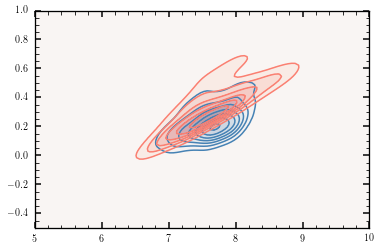

In [62]:
xmin, xmax = 5, 10
ymin, ymax = -0.5, 1

### UDG ###
name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

x = udg_cat['log_m_star']
y = np.log10(udg_cat['rhalf_phys'])

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values, )
f = np.reshape(kernel(positions).T, xx.shape)
cset = plt.contour(xx, yy, f, colors='steelblue')
cfset = plt.contourf(xx, yy, f, cmap='Blues', alpha=0.3)
# plt.scatter(x, y)
plt.xlim(xmin, xmax)


name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

x = udg_cat['log_m_star']
y = np.log10(udg_cat['rhalf_phys'])

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
cset = plt.contour(xx, yy, f, colors='salmon')
cfset = plt.contourf(xx, yy, f, cmap='Reds', alpha=0.3)
# plt.scatter(x, y)
plt.xlim(xmin, xmax)

<AxesSubplot:>

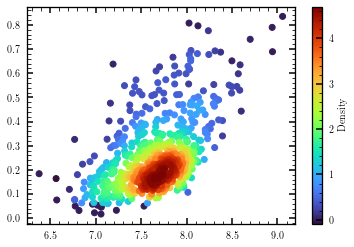

In [78]:
from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density = True )
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter( x, y, c=z, **kwargs )

    norm = Normalize(vmin = np.min(z), vmax = np.max(z))
    cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
    cbar.ax.set_ylabel('Density')

    return ax

name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]
x = udg_cat['log_m_star']
y = np.log10(udg_cat['rhalf_phys'])
density_scatter(x, y, bins = [10, 10])

In [63]:
import corner

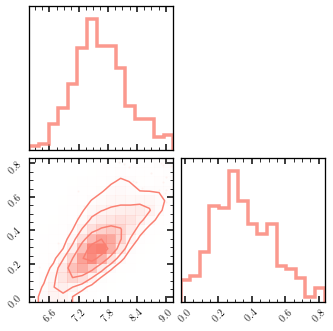

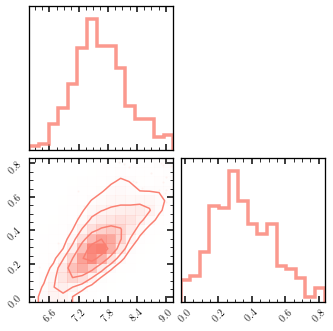

In [74]:
corner.corner(np.vstack([x, y]).T, smooth=1, bins=15, color='salmon', plot_datapoints=True)

### $R_e-M_V$ plot

(-10.0, -20.0)

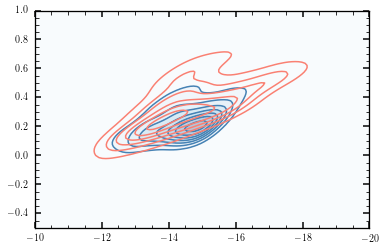

In [80]:
xmin, xmax = -10, -20
ymin, ymax = -0.5, 1

### UDG ###
name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

x = udg_cat['abs_mag'][:, 0]
y = np.log10(udg_cat['rhalf_phys'])

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
cset = plt.contour(xx, yy, f, colors='steelblue')
cfset = plt.contourf(xx, yy, f, cmap='Blues', alpha=0.3)
# plt.scatter(x, y)
plt.xlim(xmin, xmax)


name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

x = udg_cat['abs_mag'][:, 0]
y = np.log10(udg_cat['rhalf_phys'])

xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
cset = plt.contour(xx, yy, f, colors='salmon')
# cfset = plt.contourf(xx, yy, f, cmap='Reds', alpha=0.3)
# plt.scatter(x, y)
plt.xlim(xmin, xmax)

Text(0, 0.5, '$r_e\\ [\\rm kpc]$')

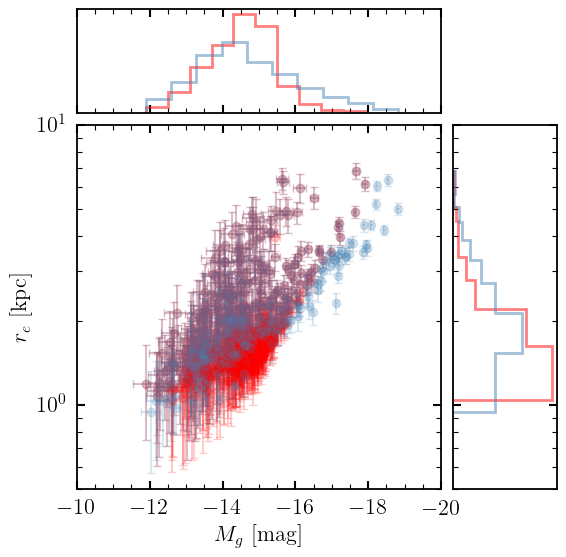

In [49]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

#### UDG ####
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

ax.errorbar(udg_cat['abs_mag'][:, 0], 
            udg_cat['rhalf_phys'], 
            xerr=udg_cat['abs_mag_err'][:, 0],
            yerr=udg_cat['rhalf_phys_err'],
            color='r', fmt='o', alpha=0.2)
ax_histx.hist(udg_cat['abs_mag'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histy.hist(udg_cat['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)

#### UPG ####
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

ax.errorbar(udg_cat['abs_mag'][:, 0], 
            udg_cat['rhalf_phys'], 
            xerr=udg_cat['abs_mag_err'][:, 0],
            yerr=udg_cat['rhalf_phys_err'],
            color='steelblue', fmt='o', alpha=0.2)
ax_histx.hist(udg_cat['abs_mag'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue', alpha=0.5)
ax_histy.hist(udg_cat['rhalf_phys'], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue', alpha=0.5)
# ax_histy.set_xscale('log')
ax_histx.set_yticks([])
ax_histy.set_xticks([])

ax.set_xlim(-10, -20)
ax.set_ylim(0.5, 10)
ax.set_yscale('log')
ax.set_xlabel(r'$M_g\ [\rm mag]$')
ax.set_ylabel(r'$r_e\ [\rm kpc]$')

Text(0, 0.5, '$\\overline{\\mu}_{\\rm eff}(g)\\ [\\rm mag\\ arcsec^{-2}]$')

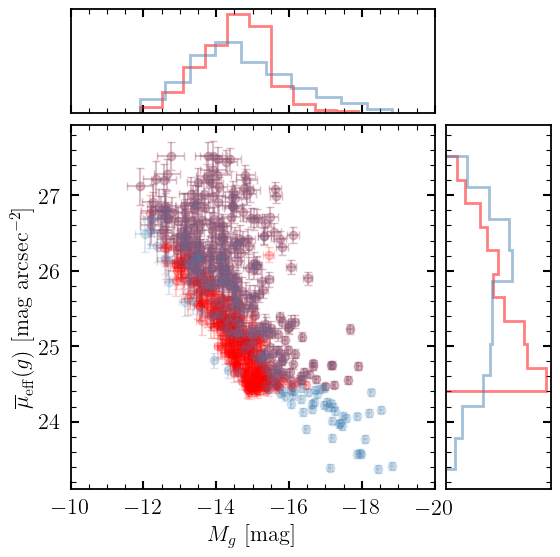

In [50]:
# Distribution of the full sample after junk cuts
fig = plt.figure(figsize=(6, 6))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

#### UDG ####
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

ax.errorbar(udg_cat['abs_mag'][:, 0], 
            udg_cat['SB_eff_avg'][:, 0], 
            xerr=udg_cat['abs_mag_err'][:, 0],
            yerr=udg_cat['SB_eff_avg_err'][:, 0],
            color='r', fmt='o', alpha=0.2)
ax_histx.hist(udg_cat['abs_mag'][:, 0], lw=2,
              histtype='step', density=True, color='r', alpha=0.5)
ax_histy.hist(udg_cat['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)

#### UPG ####
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

ax.errorbar(udg_cat['abs_mag'][:, 0], 
            udg_cat['SB_eff_avg'][:, 0], 
            xerr=udg_cat['abs_mag_err'][:, 0],
            yerr=udg_cat['SB_eff_avg_err'][:, 0],
            color='steelblue', fmt='o', alpha=0.2)
ax_histx.hist(udg_cat['abs_mag'][:, 0], lw=2,
              histtype='step', density=True, color='steelblue', alpha=0.5)
ax_histy.hist(udg_cat['SB_eff_avg'][:, 0], lw=2,
              histtype='step', density=True, orientation='horizontal', color='steelblue', alpha=0.5)
# ax_histy.set_xscale('log')
ax_histx.set_yticks([])
ax_histy.set_xticks([])

ax.set_xlim(-10, -20)
# ax.set_yscale('log')
ax.set_xlabel(r'$M_g\ [\rm mag]$')
ax.set_ylabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')

In [ ]:
from paper_figure import plot_size_distribution

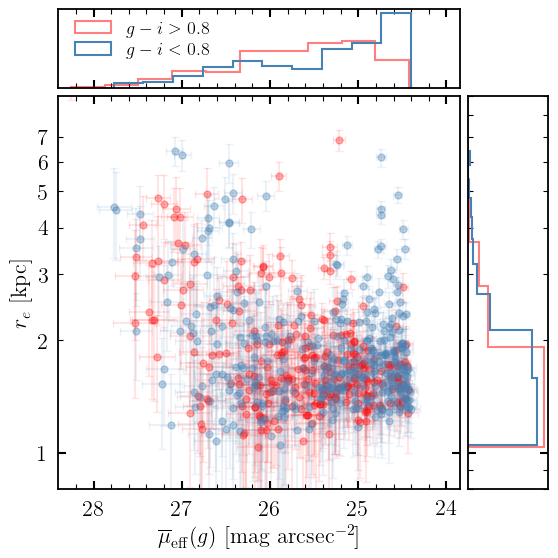

In [235]:
name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
# udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

# Distribution of the full sample after junk cuts
fig, ax = plt.subplots(figsize=(6, 6))

red = (udg_cat['g-i'].data > 0.8)

markers, caps, bars = ax.errorbar(udg_cat[red]['SB_eff_avg'][:, 0], 
            udg_cat[red]['rhalf_phys'], 
            xerr=udg_cat[red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[red]['rhalf_phys_err'],
            color='r', fmt='o', ms=5, alpha=0.3, label='$g-i > 0.8$')
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

markers, caps, bars = ax.errorbar(udg_cat[~red]['SB_eff_avg'][:, 0], 
            udg_cat[~red]['rhalf_phys'], 
            xerr=udg_cat[~red]['SB_eff_avg_err'][:, 0],
            yerr=udg_cat[~red]['rhalf_phys_err'],
            color='steelblue', fmt='o', ms=5, alpha=0.35, label='$g-i < 0.8$')
[bar.set_alpha(0.1) for bar in bars]
[cap.set_alpha(0.1) for cap in caps]

ax.set_xlim(28.4, 23.85)
ax.set_ylim(0.8, 9)
ax.set_xlabel(r'$\overline{\mu}_{\rm eff}(g)\ [\rm mag\ arcsec^{-2}]$')
ax.set_ylabel(r'$r_e\ [\rm kpc]$')
ax.set_yscale('log')
plt.tick_params(axis='y', which='minor', right=False)
ax.set_yticks([1], minor=False)
ax.set_yticklabels([1], minor=False)
ax.set_yticks([2, 3, 4, 5, 6, 7], minor=True)
ax.set_yticklabels([2, 3, 4, 5, 6, 7], minor=True)

ax_histx = ax.inset_axes((0, 1.02, 1, .2))
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.hist(udg_cat[red]['SB_eff_avg'][:, 0], lw=1.5,
              histtype='step', density=True, color='r', alpha=0.5, label='$g-i > 0.8$')
ax_histx.hist(udg_cat[~red]['SB_eff_avg'][:, 0], lw=1.5,
              histtype='step', density=True, color='steelblue', label='$g-i < 0.8$')
ax_histx.set_xlim(ax.get_xlim())

ax_histy = ax.inset_axes((1.02, 0, 0.2, 1))
ax_histy.tick_params(axis="y", which='both', labelleft=False)
ax_histy.hist(udg_cat[red]['rhalf_phys'], lw=1.5,
              histtype='step', density=True, orientation='horizontal', color='r', alpha=0.5)
ax_histy.hist(udg_cat[~red]['rhalf_phys'], lw=1.5,
              histtype='step', density=True, orientation='horizontal', color='steelblue')
ax_histy.set_yscale('log')
ax_histy.set_ylim(ax.get_ylim())

ax_histx.set_yticks([])
ax_histy.set_xticks([])
leg = ax_histx.legend(loc=(0.02, 0.26), frameon=False, fontsize=13)

### Host property
# axins = ax.inset_axes((0.5, 1-0.3, .3, .15), )
# axins.hist(udg_cat['host_z'], histtype='step', density=True, color='gray')
# axins.set_yticks([])
# axins.set_xticks([0.02, 0.04])
# axins.set_xticklabels([0.02, 0.04], fontsize=10)

plt.tight_layout()

---

In [292]:
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

In [293]:
from paper_figure import re_SB_distribution

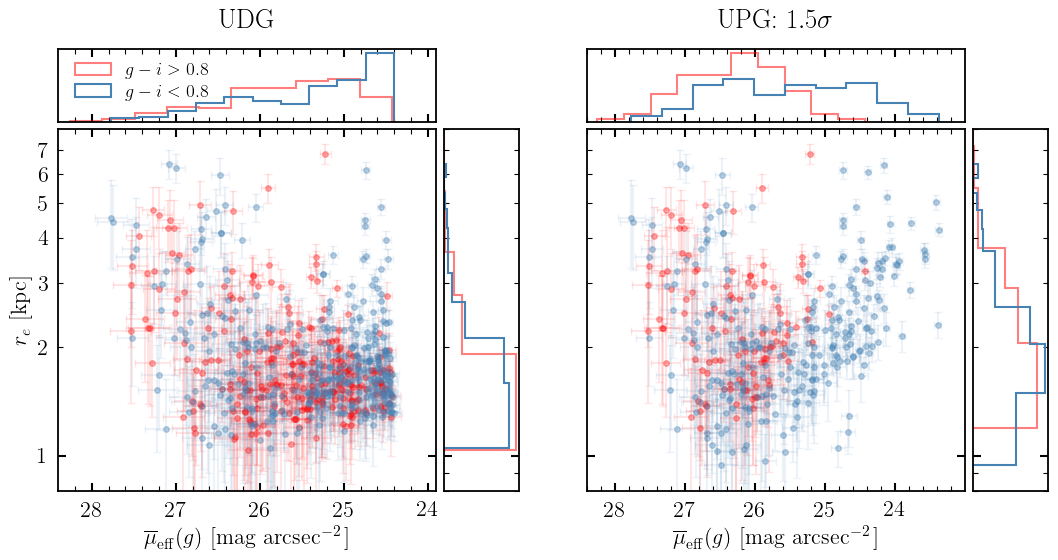

In [300]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(11.7, 4.8), sharey=True)

name = 'udg'
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
fig, ax1 = re_SB_distribution(udg_cat, ax=ax1, xlim=(28.4, 23.9))
ax1[1].set_title("UDG", y=1.1)


name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
fig, ax2 = re_SB_distribution(udg_cat, ax=ax2, xlim=(28.4, 23), show_legend=False)
ax2[0].set_ylabel('')
ax2[0].set_xticks([28, 27, 26, 25, 24], minor=False)
ax2[0].set_xticks(np.arange(28.4, 23, -0.2), minor=True)
ax2[1].set_xticks([28, 27, 26, 25, 24], minor=False)
ax2[1].set_xticks(np.arange(28.4, 23, -0.2), minor=True)

ax2[1].set_title("UPG: $1.5\sigma$", y=1.1)

plt.subplots_adjust(wspace=0.4)
# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/udg_upg_sample.pdf', 
#             bbox_inches='tight', dpi=200)

In [301]:
name = 'upg'
thresh = 1.5
udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')

In [302]:
input_cuts_cat = Table.read('./Catalog/nsa_z001_004/lsbg_after_cuts_spergel_w_missed.fits')
from sample_cuts import post_process_cat_new_rbf
cuts_cat = post_process_cat_new_rbf(input_cuts_cat)

In [303]:
print('Hosts for LSBGs after cuts:', len(np.unique(cuts_cat['host_name'])))
print('')
print('LSBGs after cuts:', len(cuts_cat))
print('UPGs:', len(udg_cat))
print('UPG hosts:', len(np.unique(udg_cat['host_name'])))

print('UPG fraction:', len(udg_cat) / len(np.unique(cuts_cat['host_name'])))
## SAGA UDG fraction: 1/6 = 0.167
junk = (udg_cat['bad_votes'] > udg_cat['good_votes'])
candy = (udg_cat['good_votes'] > udg_cat['bad_votes']) & (
    udg_cat['is_candy'] > udg_cat['is_galaxy'])
gal = (~junk) & (~candy)
print('')
print('# of Candy:', np.sum(candy))
print('# of Gal:', np.sum(gal))
print('# of Junk:', np.sum(junk))

Hosts for LSBGs after cuts: 689

LSBGs after cuts: 2510
UPGs: 371
UPG hosts: 256
UPG fraction: 0.5384615384615384

# of Candy: 318
# of Gal: 45
# of Junk: 8


In [309]:
(1 - 0.11) * 371 / 689 / 5 # UPG fraction of my sample

0.09584615384615384

In [312]:
24 / 404, np.sqrt(24) / 404

(0.0594059405940594, 0.012126186845461276)